In [10]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit

# Find the index from xvals of the value which is closest to xval.  If more than one exact match, returns the lowest index
# xvals should be spaced less than 66e6 apart
def findindex(xvals,xval): 
    minima = 66e6
    for i,elem in enumerate(xvals):
        # Update minimum difference from xval and index of the minimum difference
        if abs(xval-elem) < minima: 
            minima = abs(xval-elem) 
            index = i
    return index

# Find the x value corresponding to the max y value from the sets xvals, yvals in the range from xmin to xmax
def findmax(xvals,yvals,xmin,xmax): 
    xminindex = -666
    xmaxindex = -666
    # Find the indexes of the limits using findindex function
    xminindex = findindex(xvals,xmin)
    xmaxindex = findindex(xvals,xmax)
    # Find the max y value and the x value which is at the same index
    maxy = max(yvals[xminindex:xmaxindex])
    maxx = xvals[np.where(yvals==maxy)[0][0]]
    #maxx = 0
    return maxx,maxy #return peak as x,y coordinate tuple

def histtoplot(histdata,bins): #data to be binned, number of bins
    graph = []
    newbins=[]
    count,bincount,bars=plt.hist(histdata,bins)
    
    for i in range(len(bincount)-1):
        newbins.append(bincount[i]/2+bincount[i+1]/2)
    graph.append(newbins)
    graph.append(count)
    graph.append(len(count))
    graph.append(int(sum(count)))
    return graph #a list of 4 elements: a list of x values, a list of y values, the number of data points, & the integral of the distribution

def gaus(x, normalization,location, stdev):
    u = (x - location)/stdev
    return normalization* np.exp(-0.5*u**2)


In [11]:
#    Load a dataset of peak-to-peak values which you wish to bin into a finger spectrum

with open('../raw_data/LED/Algorithm_Test.pkl', 'rb') as f:
    p2ps = pickle.load(f)
methods = ["fit","smooth","raw","base"]

hires = 4 #high resolution at low frequencies, set to at least 2;
          #gives a factor of $hires finer frequency sampling, but with a factor of $hires smaller frequency window

hires_start = 0.2 #start high resolution requency scan at frequency=hiresoff/T/hires -- set to 0 for standard lowpass filter


hiresoff=int(np.floor(hires_start*T*hires))

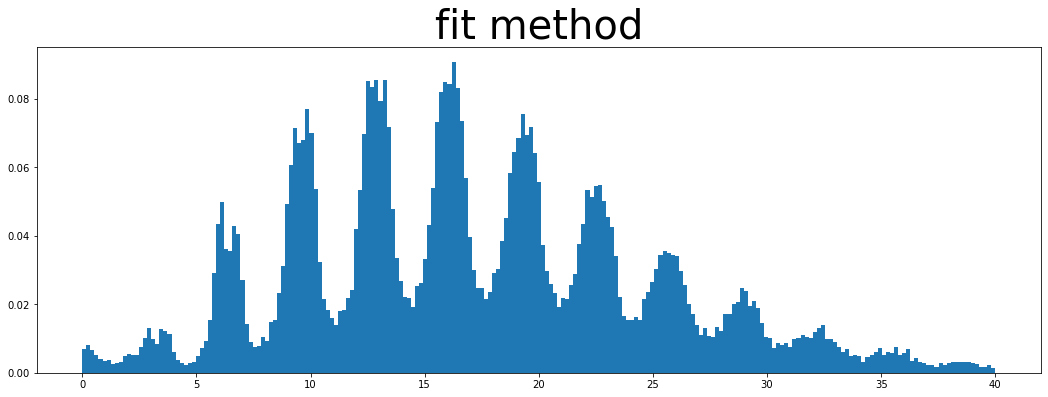

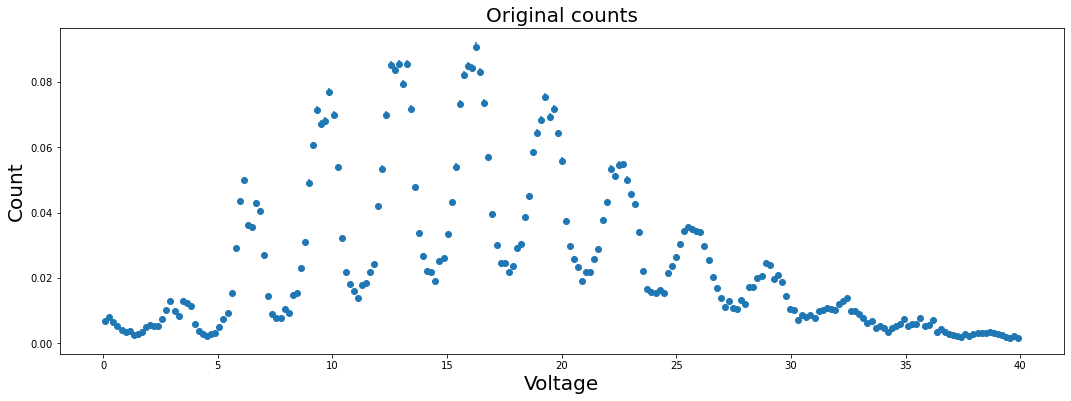

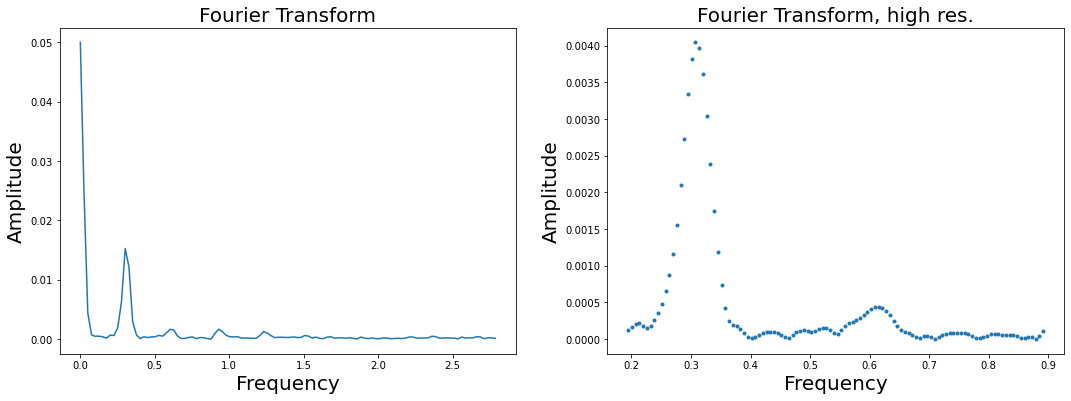

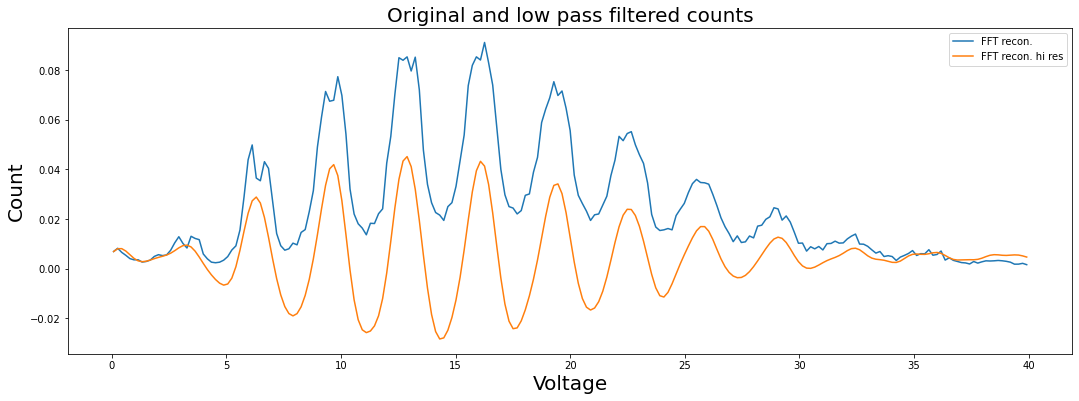

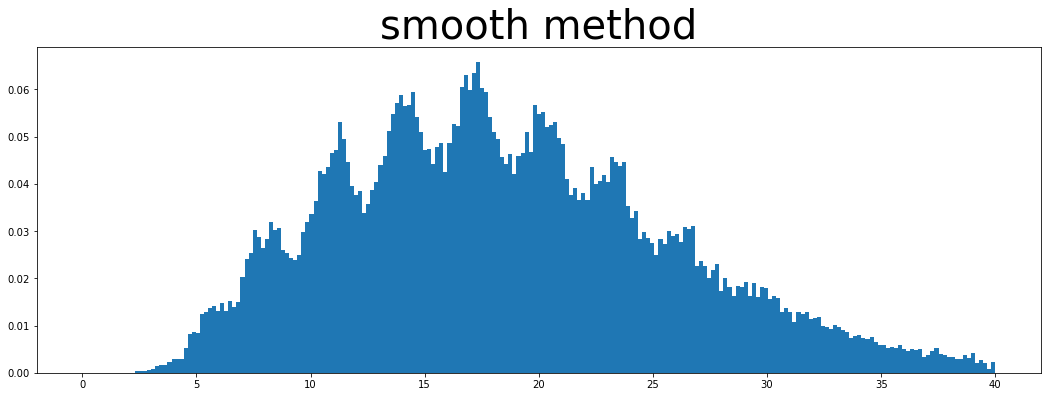

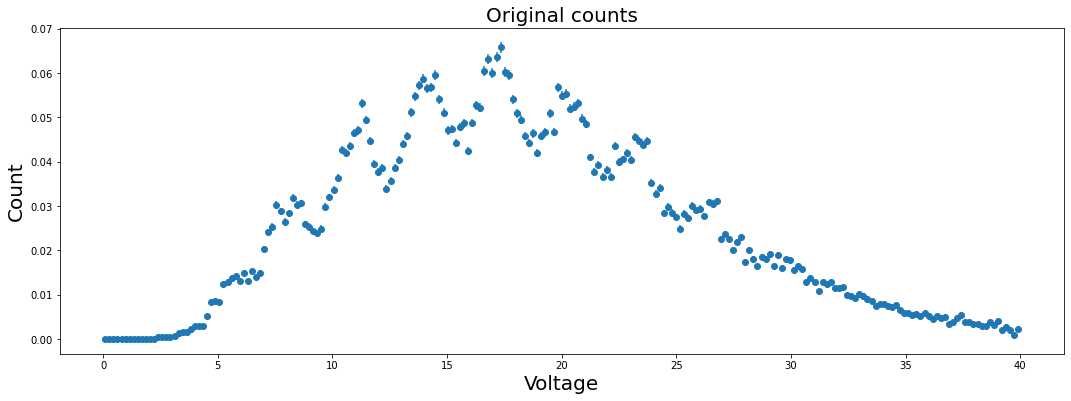

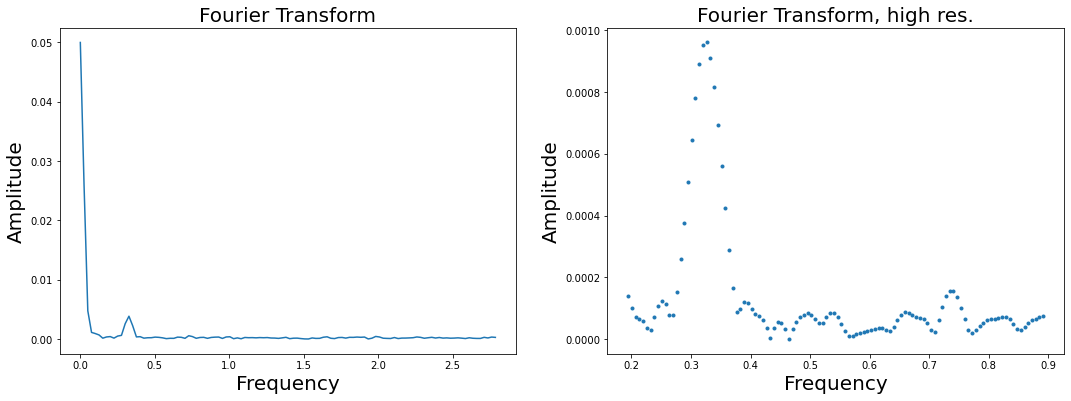

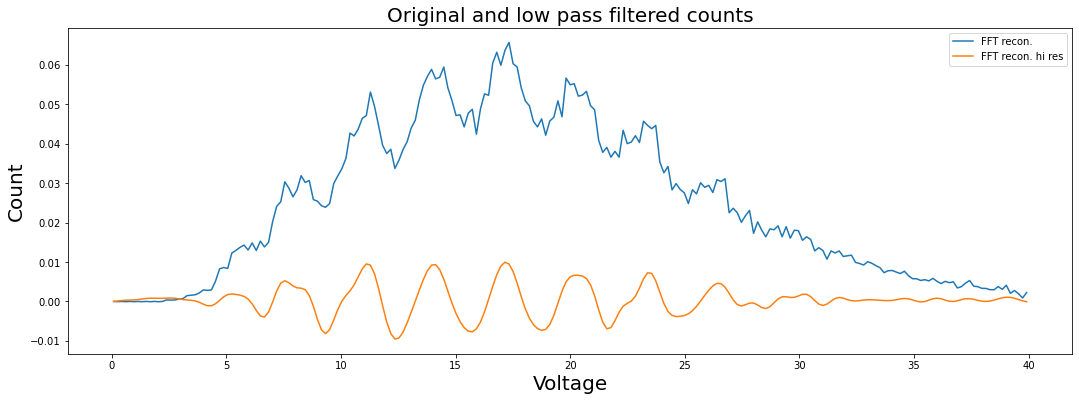

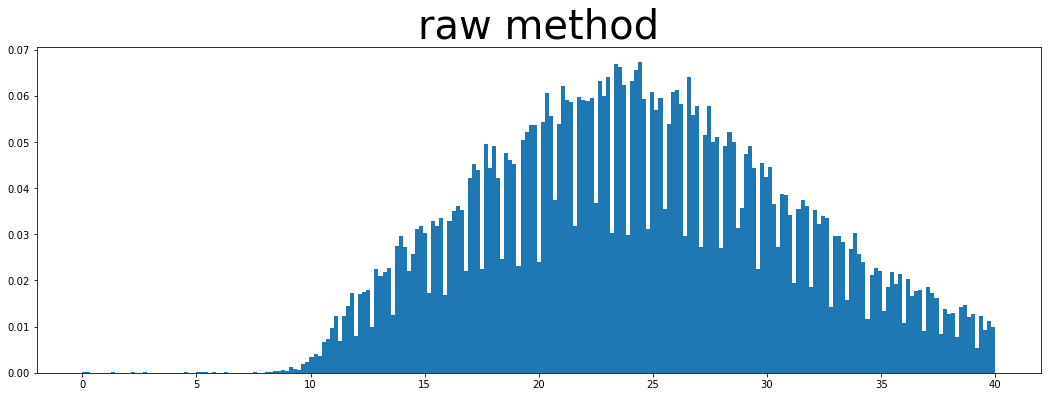

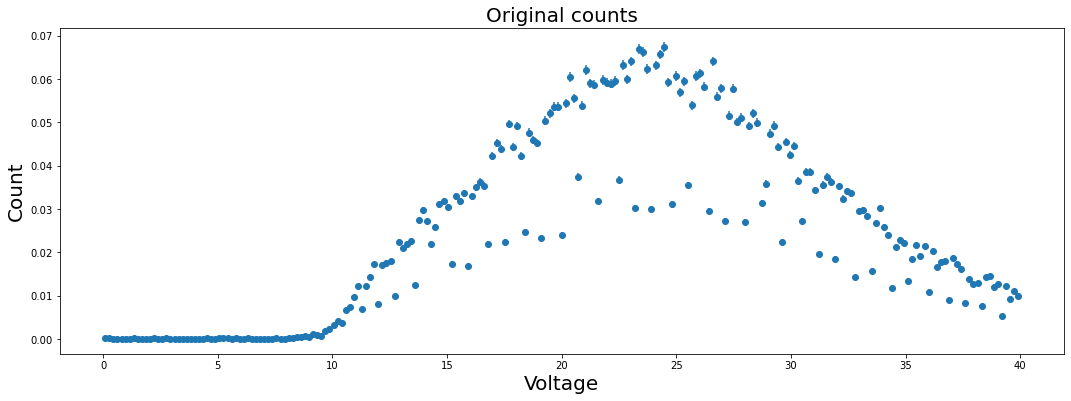

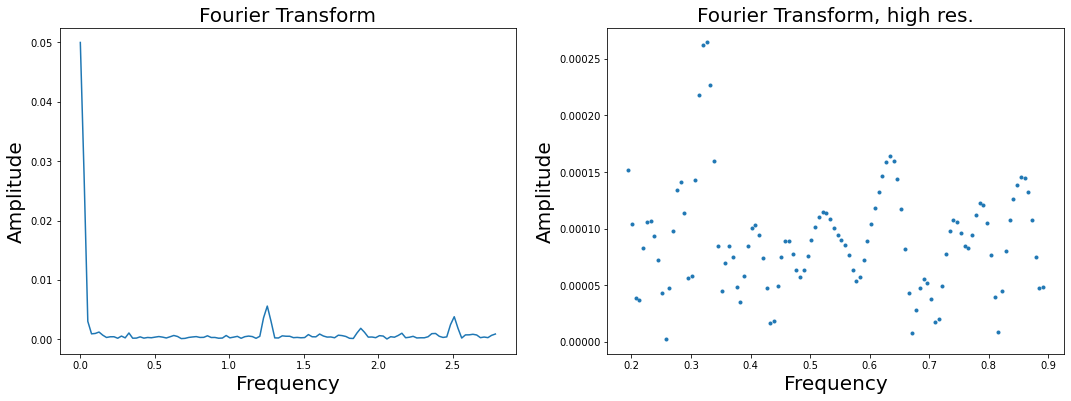

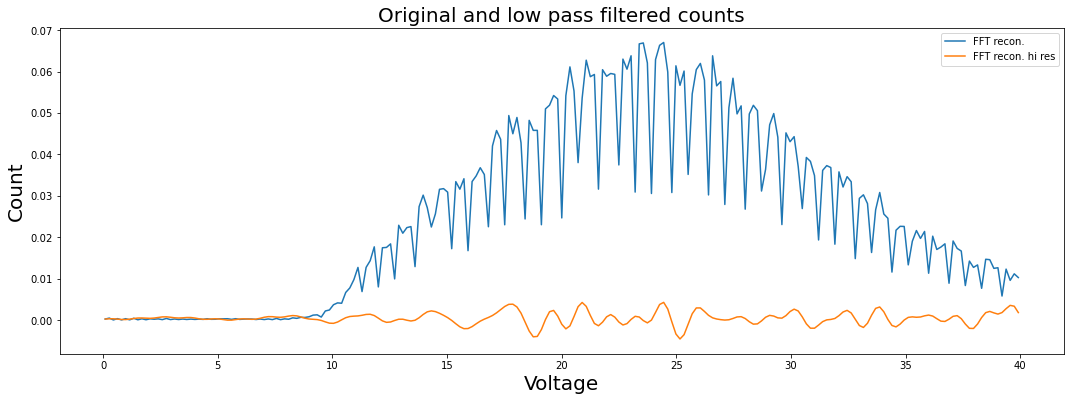

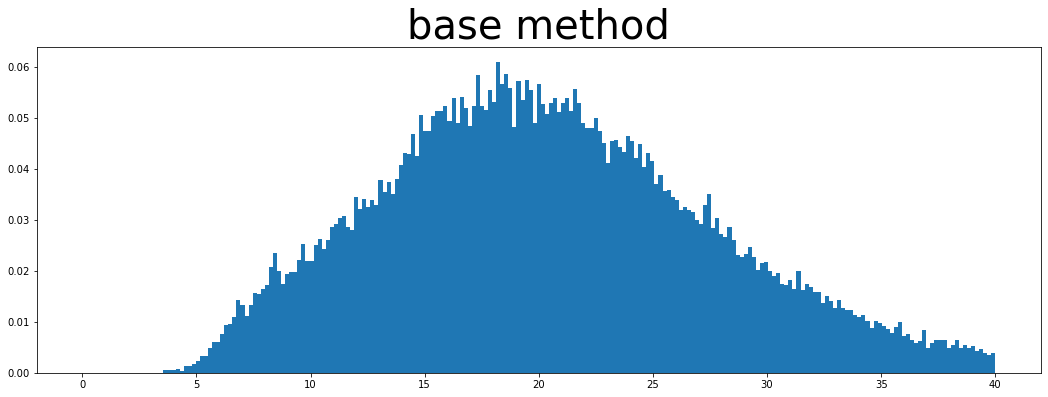

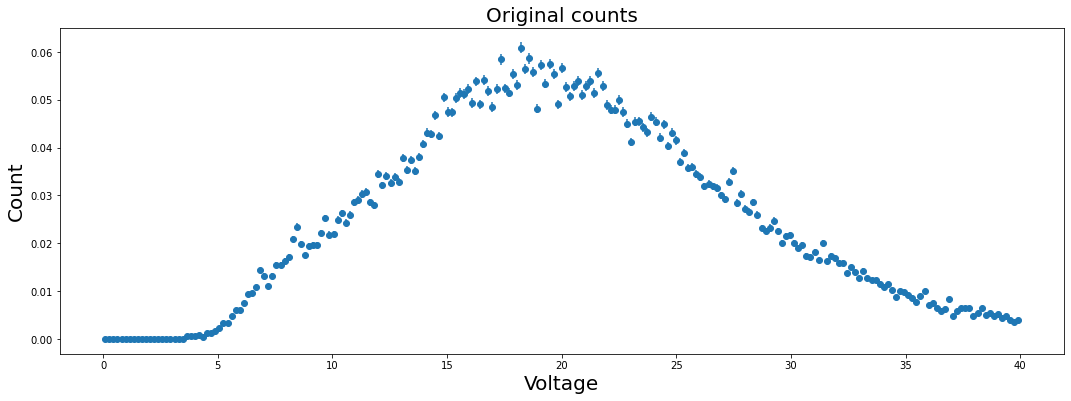

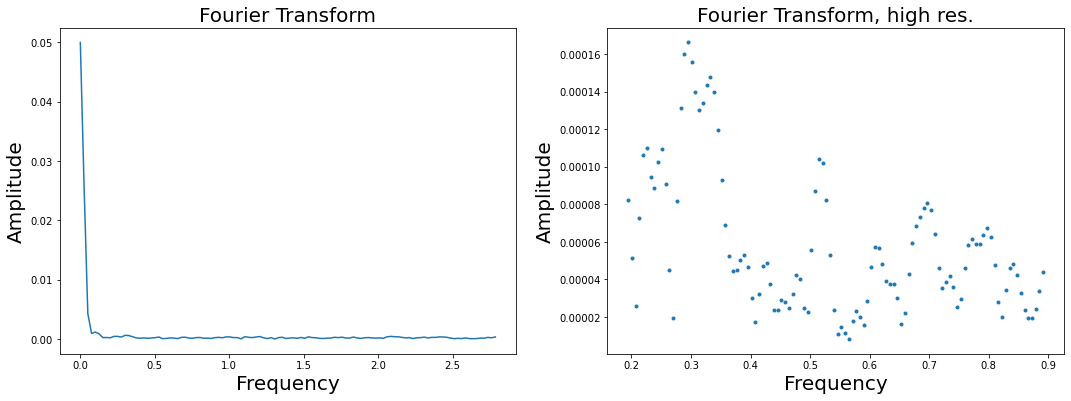

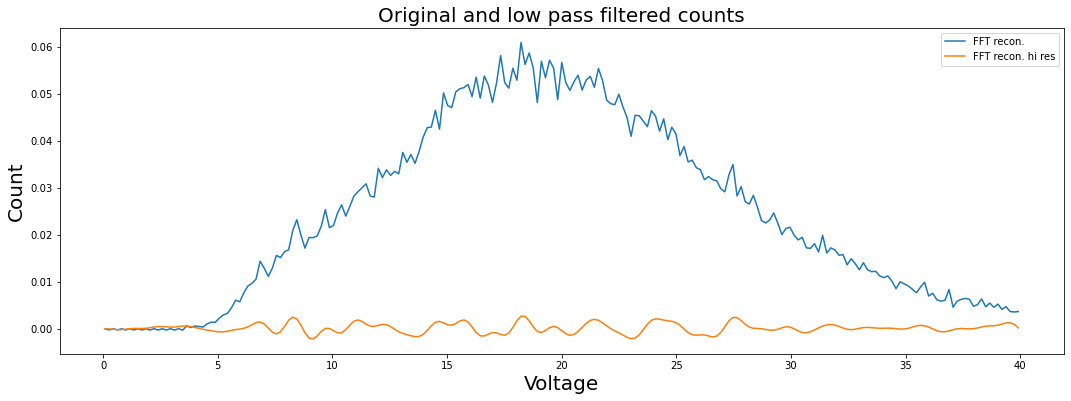

In [31]:
for method in methods:
    counts,binedges,bars=plt.hist(p2ps.eval(f"ch2_P2P_{method}"),int(np.sqrt(len(p2ps.eval(f"ch2_P2P_{method}")))),range=(0,40),density=True)
    plt.title(f"{method} method",fontsize=40)
    plt.show()
    bincenters = binedges[:-1]/2+binedges[1:]/2
    T = bincenters[-1] - bincenters[0] #total integration period
    N = len(bincenters) #number of points
    FFTs = np.zeros([3,N//2]) #Fourier frequencies, amplitudes, and phases
    FFTshr = np.zeros([3,N//2]) #high res

    # The DFT is always symmetric about its midpoint.
    # Frequencies above the midpoint are below the Nyquist criterion and does not represent real frequencies.
    for f in range(0,N//2): #iterate over frequencies
        A = 0
        Ahr = 0
        for d in range(N): #iterate over data points
            A += counts[d] * np.exp(-1j*2*np.pi*d*f/N) #integrate at frequencies f/N, A = a +ib for the fourier expansion f(t) = a*cos(wt)+bsin(wt)
            Ahr += counts[d] * np.exp(-1j*2*np.pi*d*(f+hiresoff)/N/hires)

        FFTs[0][f] = f/T #frequency
        FFTs[1][f] = la.norm(A)/N*2 #amplitude, factor of 2 to account for symmetry of DFT
        FFTs[2][f] = np.arctan2(np.imag(A),np.real(A)) #phase

        FFTshr[0][f] = (f+hiresoff)/T/hires #hires frequency
        FFTshr[1][f] = la.norm(Ahr)/N/hires*2 #hires amplitude
        FFTshr[2][f] = np.arctan2(np.imag(Ahr),np.real(Ahr)) #hires phase

    #Inverse Fourier transform
    invFT = np.zeros(N,complex)
    invFThr = np.zeros(N,complex)

    for d in range(N): #iterate over data points
        for f in range(N//2): #iterate over frequencies
            invFT[d] += FFTs[1][f] * np.exp(2j*np.pi*d/N*f+1j*FFTs[2][f])
            invFThr[d] += FFTshr[1][f] * np.exp(2j*np.pi*d/N*(f+hiresoff)/hires+1j*FFTshr[2][f])
    #take real part and add the DC offset back
    ReinvFT = np.real(invFT) + counts[0] - np.real(invFT[0])
    ReinvFThr = np.real(invFThr) + counts[0] - np.real(invFThr[0])
    #make plots
    plt.rcParams["figure.figsize"] = (18,6)
    plt.errorbar(bincenters,y=counts,yerr=np.sqrt(counts/np.size(p2ps,0)),fmt='o')

    plt.title("Original counts", size=20)
    plt.xlabel("Voltage", size=20)
    plt.ylabel("Count", size=20)
    plt.show()

    fig,ax = plt.subplots(1,2,figsize=(18,6))
    ax[0].plot(FFTs[0],FFTs[1],"-")
    ax[0].set_title("Fourier Transform", size=20)
    ax[0].set_xlabel("Frequency", size=20)
    ax[0].set_ylabel("Amplitude", size=20)

    ax[1].plot(FFTshr[0],FFTshr[1],".")
    ax[1].set_title("Fourier Transform, high res.", size=20)
    ax[1].set_xlabel("Frequency", size=20)
    ax[1].set_ylabel("Amplitude", size=20)
    plt.show()

    plt.plot(bincenters,ReinvFT,label="FFT recon.")
    plt.plot(bincenters,ReinvFThr,label="FFT recon. hi res")
    plt.legend()
    plt.title("Original and low pass filtered counts", size=20)
    plt.xlabel("Voltage", size=20)
    plt.ylabel("Count", size=20)
    plt.show()